In [ ]:
'''
forest_classification_with_image_and_point_by_using_curve_match_v3
该版本采用了十次随机抽样
该版本为主要版本
'''

In [1]:
import math
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt
import os
import scipy.signal
import copy
from sklearn.metrics import cohen_kappa_score

In [2]:
time1 = time.time()

In [3]:
RGB_imgpath      = r"E:\sentinel\4_area_2\airborn/gf_dom_xian80_49N_Clip_02m.tif"
# MTS_imgpath      = r"E:\sentinel\4_area_2\satellite/S2A_20171202_USER_MTD_SAFL2A_PDMC_20171.tif"
MTS_imgpath      = r"E:\sentinel\4_area_2\satellite/layerstacking.tif"
point_root_path  = r"E:\data\2_area_1\point\point_weneed/"
segpath     = r"E:\data\2_area_1\seg\lable_selected_sample/lable_selected_sample.shp"

In [6]:
segshape = gpd.read_file(segpath)
seggeoms = segshape.geometry.values
point_num = []
for n in np.arange(seggeoms.size):
    shape_point = gpd.read_file(point_root_path+str(n)+'.shp')
    point_num.append(len(shape_point))
    print(len(shape_point))

4868
3945
490
583
1531
1182
903
396
1825
5004
920
986
3306
6599
3443
3429
4501
6375
1307
5557
6921
4112
4921
4510
1687
3495
5389
7139
2763
16243
6836
2858
597
5641
862
2153
1165
3902
2191
1730
2042
6131
1311
734
630
2596
615
856
1500
1025
2639
1642
4258
3509
1569
2592
2579
2054
2688
4009
2856
1740
1304
722
1990
811
1649
1079
1745
3132
873
760
416
709
3985
1008
501
478
1017
2103
710
1294
738
2250
2467
1291
1318
6243
681
2026
514
2098
1348
8834
4884
1124
2851
1928
3066
2547
1143
6619
3287
2682
1785
2819
1318
328
516
641
469
425
482
313
1790
133
554
326
2116
169
1834
200
2379
522
2618
3015
505
3522
2277
2809
1220
398
517
2773
176
1559
2393
4627
48
5172
2173
1064
979
6025
564
4835
970
3586
2169
2992
1879
1510
1423
7000
1927
758
2191
4436
2576
1606
2553
4479
1440
2534
4428
2727
1265
1596
1468
1861
3056
834
1763
5456
2876
447
2664
618
1921
1009
932
4116
3132
3631
622
2625
5809
1786
1523
895
586
2998
1963
4176
480
696
1241
5325
1036
298
2160
1403
9823
2415
2268
1538
3735
900
1719
5956
2058
10

In [9]:
sum(point_num)/(seggeoms.size)

2687.632075471698

In [11]:
bins = 100  # Number of bins

In [12]:
def process(recv_size,total_size):
    recv_size = recv_size + 1
    width=50
    if recv_size <= total_size:
        percent=recv_size / total_size
        show_str=('%%-%ds' %width) %(int(width*percent) * '>')
        print('\r%s %d%%' %(show_str,int(100*percent)),end='')
# Extract raster values from shapefile
def ShpExtract(spgeom, img, n):
    pgeoms = [mapping(spgeom[n])]
    out_image, _ = mask(img, pgeoms, crop=True) # out_image is a minimum enclosing rectangle of a polygon, but the values outside the polygon are 0
    imgvalue = []
    for i in np.arange(out_image.shape[1]):
        for j in np.arange(out_image.shape[2]):
            if (out_image[:, i, j].tolist().count(0) == img.count) == False:    # exclude the values outside the polygon
                imgvalue.append(out_image[:, i, j])
    return imgvalue

'''
抽取均值
'''
def Mean(imgvalue):
    means = []
    size = np.array(imgvalue).shape
#   print(size) = (像元数，波段数)
    for n in range(size[1]):
        sum = 0
        for k in range(size[0]):
            sum = sum + imgvalue[k][n]
        means.append(sum)
    mean = np.array(means)/size[0]
    return(mean)

# Generate histogram
def HistFreq(value):
    freq = []
    for i in np.arange(bands):
        hist, _ = np.histogram(value[:, i], range=(0, 1), bins=bins, density=True)
        hist = hist / sum(hist)
        hist[hist == 0] = 0.0000001
        freq.append(hist)
    return freq

# cumulative distribution function (CDF)
def CDFgeneration(objfreq):
    objcdf = []
    for i in np.arange(bands):
        for j in np.arange(bins):
            cdf = np.true_divide(sum(objfreq[i][0:j+1]),sum(objfreq[i]))
            objcdf.append(cdf)
    return np.array(objcdf).reshape(bands,bins)

In [13]:
#
'''
读取矢量文件
'''
# Read training and testing samples, and segmentation shapefiles (if needed)
segshape = gpd.read_file(segpath)
seggeoms = segshape.geometry.values
'''
读取RGB影像
'''
src = rasterio.open(RGB_imgpath)    # Read raster image
raster = src.read()
raster = (raster-np.min(raster)) / (np.max(raster)-np.min(raster))  # Stretch image values within the range of 0~1
raster[raster == 0.000000] = 0.0000001  # Rectify 0 value, otherwise extracting raster values from shapefile may occur an error
with rasterio.open('data/temp_RGB.tif', mode='w', driver='GTiff',
                       width=src.width, height=src.height, count=src.count,
                       crs=src.crs, transform=src.transform, dtype=raster.dtype) as dst:
    dst.write(raster)
src = rasterio.open('data/temp_RGB.tif') # Write and re-read the transformed image
bands = 3   # Number of bands

'''
读取_MTS影像
'''
src_MTS = rasterio.open(MTS_imgpath)    # Read raster image
raster_MTS = src_MTS.read()
raster_MTS = (raster_MTS-np.min(raster_MTS)) / (np.max(raster_MTS)-np.min(raster_MTS))  # Stretch image values within the range of 0~1
raster_MTS[raster_MTS == 0.000000] = 0.0000001  # Rectify 0 value, otherwise extracting raster values from shapefile may occur an error
with rasterio.open('data/temp_MTS.tif', mode='w', driver='GTiff',
                       width=src_MTS.width, height=src_MTS.height, count=src_MTS.count,
                       crs=src_MTS.crs, transform=src_MTS.transform, dtype=raster_MTS.dtype) as dst:
    dst.write(raster_MTS)
src_MTS = rasterio.open('data/temp_MTS.tif') # Write and re-read the transformed image

bands_MTS = src_MTS.count   # Number of bands

In [14]:
'''
抽取训练的信息
'''
print('得到了各个数据的结果，包括生成的曲线以及均值：trainfreq, traincdf, train_sample_mean')
# Generate curves (PDF and CDF) from all the training objects
trainfreq, traincdf, train_sample_mean,point_cloud, label_y = [], [], [], [], []  # Histogram and cumulative distribution function of training objects
for n in np.arange(seggeoms.size):
    # 抽取RGB信息
    trainvalue = ShpExtract(seggeoms, src, n)  
    trainvalue = np.array(trainvalue)
    hist = HistFreq(trainvalue) 
    # 开始滤波
    hist_temp = []
    for k_22 in range(3):
        copy_counts = hist[k_22]
        length_2 = 5
        h = ([0.0625, 0.25, 0.375, 0.25, 0.0625])
        counts_conv = scipy.signal.convolve(copy_counts, h)
        hist_conv  = counts_conv[2:102]
        
        counts_conv = scipy.signal.convolve(hist_conv, h)
        hist_conv  = counts_conv[2:102]
        
        hist_temp.append(hist_conv)
    # 滤波结束
    trainfreq.append(hist)
    cdf = CDFgeneration(hist)
    traincdf.append(cdf)
    

    # 抽取多光谱信息
    train_samplevalue_MTS = ShpExtract(seggeoms, src_MTS, n)
    l = Mean(train_samplevalue_MTS)
    train_sample_mean.append(l)
    # 抽取点云信息
    shape_point = gpd.read_file(point_root_path+str(n)+'.shp')
    point_hist, _ = np.histogram(np.array(shape_point.norm.values), bins=100,range=(0,1), density=True)
    # 归一化操作，注释了试一试
    point_hist = point_hist/len(point_hist)
    # 开始滤波
    copy_counts = point_hist
    length_2 = 5
    h = ([0.0625, 0.25, 0.375, 0.25, 0.0625])
    counts_conv = scipy.signal.convolve(copy_counts, h)
    hist        = counts_conv[2:102]
    hist_1      = counts_conv[2:102]
    # 开始第二次滤波
    copy_counts = hist
    length_2 = 5
    h = ([0.0625, 0.25, 0.375, 0.25, 0.0625])
    counts_conv = scipy.signal.convolve(copy_counts, h)
    hist        = counts_conv[2:102]
    hist_1      = counts_conv[2:102]
    # 开始第三次滤波
    copy_counts = hist
    length_2 = 5
    h = ([0.0625, 0.25, 0.375, 0.25, 0.0625])
    counts_conv = scipy.signal.convolve(copy_counts, h)
    hist        = counts_conv[2:102]
    hist_1      = counts_conv[2:102]
    # 开始第四次滤波
    copy_counts = hist
    length_2 = 5
    h = ([0.0625, 0.25, 0.375, 0.25, 0.0625])
    counts_conv = scipy.signal.convolve(copy_counts, h)
    hist        = counts_conv[2:102]
    hist_1      = counts_conv[2:102]
    
    hist        = hist = [0.000001 if i ==0 else i for i in hist]
    # 滤波结束
    
    point_cloud.append(hist)
    label_y.append(segshape.lable.values[n])
    # 进度条
    process(n,seggeoms.size)
    
    # 将多光谱添加到cdf,点云的统计值
for k in np.arange(seggeoms.size):
    trainfreq[k].append(np.array(train_sample_mean[k]))
    trainfreq[k].append(np.array(point_cloud[k]))
if len(trainfreq[0]) == 5:
    print('right')


得到了各个数据的结果，包括生成的曲线以及均值：trainfreq, traincdf, train_sample_mean
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 100%right


In [16]:
plot_trainfreq = copy.deepcopy(trainfreq)

In [9]:
# 临时展平数据,绘制数据
'''
['八角','椴树','观光木','灰木莲','火力楠','巨尾桉','马尾松','米老排','杉木','湿地松','尾叶桉']
['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']
'''
data = []
for k1 in range(len(trainfreq)):
    data.append([])
    for k2 in range(len(trainfreq[k1])):
        for k3 in range(len(trainfreq[k1][k2])):
            data[k1].append(trainfreq[k1][k2][k3])

In [88]:
segshape

,ID,area,classname,lable,ord,geometry
0,32484,2787.40,马尾松,6,0,"POLYGON ((229022.064 2540882.770, 229023.064 2..."
1,32508,2070.08,马尾松,6,1,"POLYGON ((229054.464 2540865.570, 229054.864 2..."
2,1258,1263.24,尾叶桉,10,2,"POLYGON ((230643.864 2543121.370, 230644.264 2..."
3,4397,1111.60,尾叶桉,10,3,"POLYGON ((230663.864 2543085.570, 230664.264 2..."
4,4336,2021.56,尾叶桉,10,4,"POLYGON ((230640.664 2543066.970, 230641.464 2..."
...,...,...,...,...,...,...
313,4398,1311.32,尾叶桉,10,313,"POLYGON ((230695.864 2543082.770, 230697.664 2..."
314,4403,1983.60,尾叶桉,10,314,"POLYGON ((230704.864 2543030.370, 230705.464 2..."
315,4409,2526.28,尾叶桉,10,315,"POLYGON ((230673.664 2542979.570, 230673.864 2..."
316,8015,850.96,八角,0,316,"POLYGON ((228198.464 2542488.570, 228198.464 2..."


马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


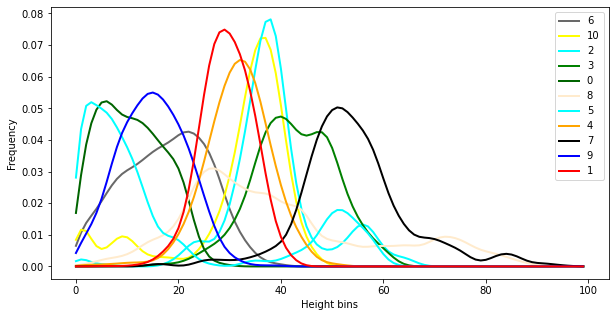

In [18]:
marker_ =['.', 'o', 'v', '^', '<', '>', '1', '2', '*', '+', 'x', '3']
color = ['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']

plt.figure(figsize=(10,5))
plt.tick_params(labelsize=10)

# 绘制每个种类
# labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
# plt.grid(True)
for n in np.arange(seggeoms.size):
    if n == 0 or n == 2 or n == 5 or n == 13 or n == 36 or n == 62 or n == 108 or n == 128 or n == 146 or n == 231 or n == 277   :
        print(segshape.classname.values[n])
        x = np.arange(100)
        y = plot_trainfreq[n][4]
        plt.plot(x,y,color=color[int(segshape.lable.values[n])], label=str(segshape.lable.values[n]), linewidth=2)
        plt.legend(loc='upper right')
        plt.xlabel('Height bins')
        plt.ylabel('Frequency')
plt.show()

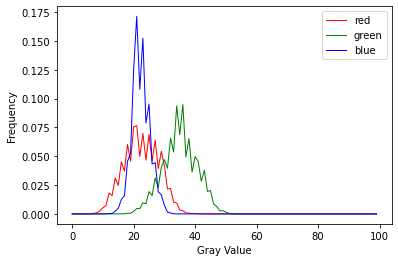

In [24]:
# 绘制RGB每个通道的所有情况
# plt.grid(True)
color = ['red','green','blue']
color_name = ['red','green','blue']
for n_1 in range(3):
    x = np.arange(100)
    y = plot_trainfreq[n][n_1]
    plt.tick_params(labelsize=10)
    plt.plot(x,y,color=color[int(n_1)], label=color_name[n_1], linewidth=1)
    plt.legend(loc='best')
    plt.xlabel('Gray Value')
    plt.ylabel('Frequency')
plt.show()

马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


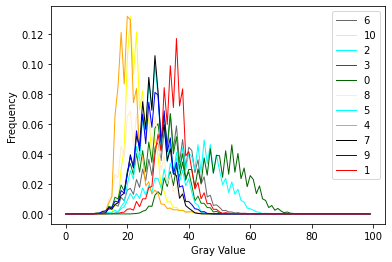

马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


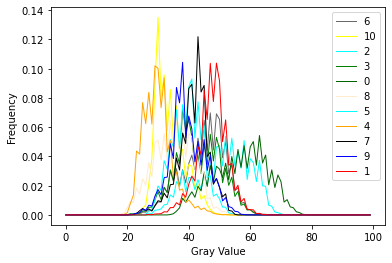

马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


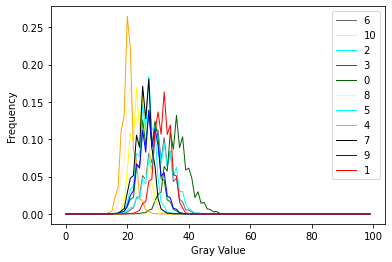

In [160]:
# 绘制RGB每个通道的所有情况
# plt.grid(True)

for n_1 in range(3):

    for n in np.arange(seggeoms.size):
        if n == 0 or n == 2 or n == 5 or n == 13 or n == 36 or n == 62 or n == 108 or n == 128 or n == 146 or n == 231 or n == 277   :
            print(segshape.classname.values[n])
            x = np.arange(100)
            y = plot_trainfreq[n][n_1]
            plt.tick_params(labelsize=10)
            plt.plot(x,y,color=color[int(segshape.lable.values[n])], label=str(segshape.lable.values[n]), linewidth=1)
            plt.legend(loc='best')
            plt.xlabel('Gray Value')
            plt.ylabel('Frequency')
    plt.show()

In [27]:
len(plot_trainfreq[0][3])

48

马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


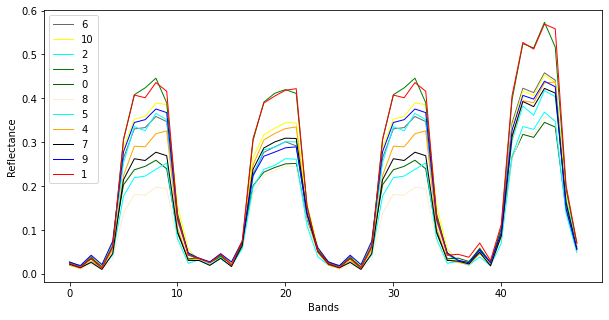

In [35]:
# 绘制RGB单个情况
# plt.grid(True)
plt.figure(figsize=(10,5))
color = ['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']
for n in np.arange(seggeoms.size):
    if n == 0 or n == 2 or n == 5 or n == 13 or n == 36 or n == 62 or n == 108 or n == 128 or n == 146 or n == 231 or n == 277   :
        print(segshape.classname.values[n])
        x = np.arange(48)
        y = plot_trainfreq[n][3]
        plt.tick_params(labelsize=10)
        plt.plot(x,y,color=color[int(segshape.lable.values[n])], label=str(segshape.lable.values[n]), linewidth=1)
        plt.legend(loc='best')
        plt.xlabel('Bands')
        plt.ylabel('Reflectance')
plt.show()

马尾松
尾叶桉
观光木
灰木莲
八角
杉木
巨尾桉
火力楠
米老排
湿地松
椴树


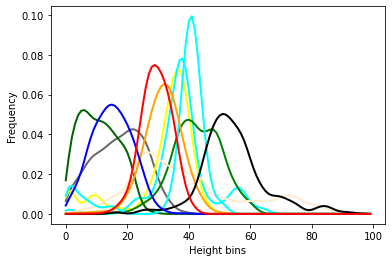

In [210]:
# 绘制点云的单个情况
# plt.grid(True)
# legend_B = ['Band R','Band G','Band B']
# color_B  = ['red','green','blue']
for n in np.arange(seggeoms.size):
    if n == 0 or n == 2 or n == 5 or n == 13 or n == 36 or n == 62 or n == 121 or n == 128 or n == 146 or n == 231 or n == 277   :
        print(segshape.classname.values[n])
        x = np.arange(100)
        y = plot_trainfreq[n][4]
        plt.tick_params(labelsize=10)
        plt.plot(x,y,color=color[int(segshape.lable.values[n])], linewidth=2)
        plt.xlabel('Height bins')
        plt.ylabel('Frequency')
plt.show()

尾叶桉
巨尾桉


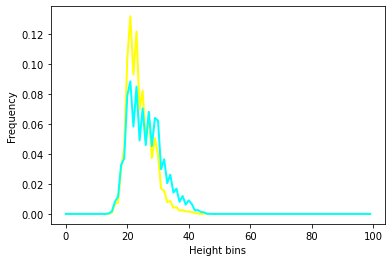

In [216]:
for n in np.arange(seggeoms.size):
    if  n == 2 or n == 121:
        print(segshape.classname.values[n])
        x = np.arange(100)
        y = plot_trainfreq[n][0]
        plt.tick_params(labelsize=10)
        plt.plot(x,y,color=color[int(segshape.lable.values[n])], linewidth=2)
        plt.xlabel('Height bins')
        plt.ylabel('Frequency')
plt.show()

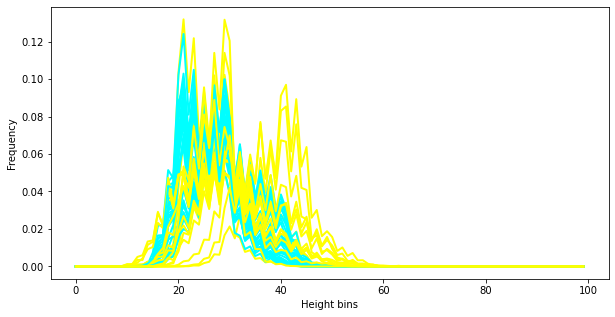

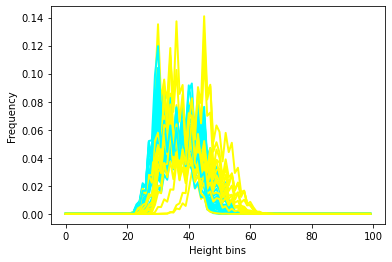

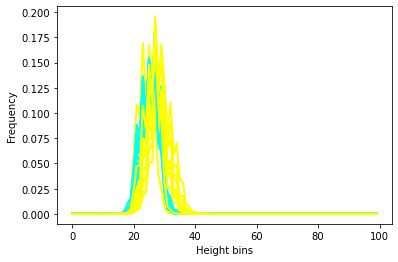

In [204]:
# 绘制光谱某一类别
marker_ =['.', 'o', 'v', '^', '<', '>', '1', '2', '*', '+', 'x', '3']
color = ['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']
plt.figure(figsize=(10,5))
# plt.grid(True)
for n_k in range(3):
    for n in np.arange(seggeoms.size):
        if segshape.classname.values[n] == '尾叶桉' or segshape.classname.values[n] == '巨尾桉':
            x = np.arange(100)
            if n_k == 0:
                y = data[n][0:100]
            if n_k == 1:
                y = data[n][100:200]
            if n_k == 2:
                y = data[n][200:300]
#         plt.plot(x,y,color=color[int(segshape.lable.values[n])], label=str(segshape.lable.values[n]), linewidth=2)
            plt.plot(x,y,color=color[int(segshape.lable.values[n])], linewidth=2)
#         plt.legend(loc='upper right')
            plt.xlabel('Height bins')
            plt.ylabel('Frequency')  
    plt.show()

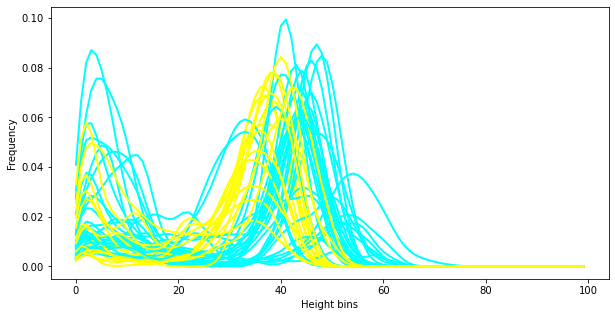

In [201]:
# 绘制点云某一类别
marker_ =['.', 'o', 'v', '^', '<', '>', '1', '2', '*', '+', 'x', '3']
color = ['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']
plt.figure(figsize=(10,5))
# plt.grid(True)
for n in np.arange(seggeoms.size):
    if segshape.classname.values[n] == '尾叶桉' or segshape.classname.values[n] == '巨尾桉':
        x = np.arange(100)
        y = data[n][348:448]
#         plt.plot(x,y,color=color[int(segshape.lable.values[n])], label=str(segshape.lable.values[n]), linewidth=2)
        plt.plot(x,y,color=color[int(segshape.lable.values[n])], linewidth=2)
#         plt.legend(loc='upper right')
        plt.xlabel('Height bins')
        plt.ylabel('Frequency')  
plt.show()

In [9]:
# 选定的一些结果
# ppt权重
# weightarr = [1.8, 1.8, 1.8, 1, 2.5]
# 最终选定的较好的结果一
#weightarr = [1, 1.2, 1.15, 0.159, 0.985]
# 都能上0.9的权重
# weightarr = [1.8, 1.8, 1.8, 1, 2]
# 最终的权重
# 最终的权重
'''
'''
# 最终的权重
# 最终的权重
weightarr = [1.66, 2, 1.9, 0.8, 2]
# 最终的权重
# 最终的权重
'''
'''
# 对比试验的权重
# weightarr = [1,1,1,0,0]
# weightarr = [1, 1.2, 1.15, 0, 0]
# weightarr = [1, 1.2, 1.15, 0.02,0]

# weightarr = [0,0,0,0,1]
# weightarr = [1,1,1,1,0]
# weightarr = [1,1,1,0,1]


# 原来的权重

# weightarr = [1.66, 2, 1.9, 0, 2]
# 一千次权重
# weightarr = [1.6,1.6,1.6,1,2.4]

# 初始化一样的权重
# weightarr = [2/3, 2/3, 2/3, 0, 0]
# ppt权重
# weightarr = [1.8, 1.8, 1.8, 1, 2.5]
# 最终选定的较好的结果一
# weightarr = [1, 1.2, 1.15, 0.159, 0.985]

# weightarr = [1,1,1,0,0]
# weightarr = [0,0,0,1,0]
# weightarr = [0,0,0,0,1]
# weightarr = [1,1,1,1,0]
# weightarr = [1,1,1,0,1]


'\n'

In [10]:
# Kullback-Leibler (KL) divergence
# 改了+0.000001，后面需要搞回来
def KLmethod(ptrainfq, ptestfq):
    sumdiff = 0
    xyz = []
    tenp__ = []
    for k in np.arange(5):
        train = ptrainfq[k]
        test = ptestfq[k]
        diff1 = abs(sum(np.log(np.true_divide(train,test))*train))
        diff2 = abs(sum(np.log(np.true_divide(test,train))*test))
        diff = (diff1 + diff2) / 2
        xyz.append(diff)
        sumdiff = sumdiff + diff * weightarr[k]
#     print(xyz)
    return sumdiff
def CAMmethod(ptrainfq, ptestfq):
    sumdiff = 0
    for k in np.arange(5):
        train = ptrainfq[k]
        test = ptestfq[k]
        num1 = sum(train*test)
        num2 = sum(train*train)
        num3 = sum(test*test)
        tmp = np.true_divide(num1,math.sqrt(num2)*math.sqrt(num3))
        if (abs(tmp-1)<0.000001):
            diff = 0
        else:
            diff = math.acos(tmp)
        sumdiff = sumdiff + diff * weightarr[k]
    return sumdiff

def CMRSSDAmethod(ptrainfq, ptestfq):
    sumdiff = 0
    for k in np.arange(bands):
        train = ptrainfq[k]
        test = ptestfq[k]
        diff = math.sqrt(sum((train-test)*(train-test)))
        sumdiff = sumdiff + diff * weightarr[k]
    return sumdiff


In [11]:
'''
已传入待分类的每一块
调用并判断使用方法
遍历用于训练的每一块
'''
def Wei2Cls(test_freq, code):
    diffall = []
    # 14 是训练的分块
    for i in np.arange(len(x_train)):
        if code == 'KL':
            sumdiff = KLmethod(x_train[i], test_freq)
        elif code == 'CAM':
            sumdiff = CAMmethod(x_train[i], test_freq)
        elif code == 'CMRSSDA':
            sumdiff = CMRSSDAmethod(x_train[i], test_freq)
        diffall.append(sumdiff)
    cls = y_train[diffall.index(min(diffall))]
    return cls



In [28]:
# 使用循环记录每次的值
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
r_1 = []
r_2 = []
r_3 = []
# 最终确定的参数
np.random.seed(9)
# num_random_state = np.random.randint(0, 1000000000, size=(10,))
num_random_state = np.random.randint(0, 1000000000, size=(10,))
print(num_random_state)
target_name = ['八角','椴树','观光木','灰木莲','火力楠','巨尾桉','马尾松','米老排','杉木','湿地松','尾叶桉']
for t_1 in range(len(num_random_state)):
    print('*****************************')
    print(t_1)
    print('*****************************')
#     process(t_1,len(num_random_state))
    x_train, x_test, y_train, y_test = train_test_split(trainfreq, label_y, test_size=0.8, 
                                                        stratify=label_y, random_state=num_random_state[t_1])
    
    # 创建列表用于存放最终分类结果
    bands = 5   # Number of bands
    clsFinal = []
    # 存放分类方法用于循环调用不同的方法
    methstr = ['KL','CAM','CMRSSDA']
    # methstr = ['CMRSSDA']
    '''
    遍历每一块
    遍历每块的每个波段
    '''
    for n in np.arange(len(x_test)):
        one_segfreq = x_test[n]
    # 此处有3种方法，调用Wei2Cls()函数
        for i in np.arange(3):
            cls = Wei2Cls(one_segfreq, methstr[i])
            clsFinal.append(cls)
    pre = np.array(clsFinal).reshape(len(x_test),3)
    
    expected = y_test
    predicted = pre[:, 0]
    confusion_matrix_ = confusion_matrix(expected, predicted)
    
    ######保存成CSV######
    if t_1 ==0:
        KL_result =pd.DataFrame(columns=('class','pre','T'))
        for n_mc in range(255):
            if expected[n_mc] == pre[n_mc, 0]:
                record = 1
            else :
                record = 0
            KL_result = KL_result.append([{'class':expected[n_mc],'T':record,'pre':pre[n_mc, 0]}], ignore_index=True)
        KL_result.to_csv("E:/data/Acc/KL_result.csv")
        
        CAM_result =pd.DataFrame(columns=('class','pre','T'))
        for n_mc in range(255):
            if expected[n_mc] == pre[n_mc, 1]:
                record = 1
            else :
                record = 0
            CAM_result = CAM_result.append([{'class':expected[n_mc],'T':record,'pre':pre[n_mc, 1]}], ignore_index=True)
        CAM_result.to_csv("E:/data/Acc/CAM_result.csv")
    if t_1 ==9:
        CMRSSDA_result =pd.DataFrame(columns=('class','pre','T'))
        for n_mc in range(255):
            if expected[n_mc] == pre[n_mc, 2]:
                record = 1
            else :
                record = 0
            CMRSSDA_result = CMRSSDA_result.append([{'class':expected[n_mc],'T':record,'pre':pre[n_mc, 2]}], ignore_index=True)
        CMRSSDA_result.to_csv("E:/data/Acc/CMRSSDA_result.csv")
    ######保存成CSV######
    print('--------------------KL-------------------------')
    print('confusion_matrix_')
    print(confusion_matrix_)
    print('confusion_matrix_')
    kappa_value = cohen_kappa_score(expected, predicted)
    print("kappa值为 %f" % kappa_value)
    r_1.append(sum(confusion_matrix_.diagonal())/sum(sum(confusion_matrix_)))
    print(r_1)
    print(classification_report(expected, predicted, labels=None, sample_weight=None, digits=2))
    print('--------------------------------')
    
    predicted = pre[:, 1]
    confusion_matrix_ = confusion_matrix(expected, predicted)
    r_2.append(sum(confusion_matrix_.diagonal())/sum(sum(confusion_matrix_)))
    confusion_matrix_ = confusion_matrix(expected, predicted)
    print('-----------------------------CAM----------------------')
    print('confusion_matrix_')
    print(confusion_matrix_)
    kappa_value = cohen_kappa_score(expected, predicted)
    print("kappa值为 %f" % kappa_value)
    print(r_2)
    print(classification_report(expected, predicted, labels=None, sample_weight=None, digits=2))
    print('--------------------------------')
    
    predicted = pre[:, 2]
    confusion_matrix_ = confusion_matrix(expected, predicted)
    r_3.append(sum(confusion_matrix_.diagonal())/sum(sum(confusion_matrix_)))
    confusion_matrix_ = confusion_matrix(expected, predicted)
    print('-------------------CMRSSDA----------------------------------')
    print('confusion_matrix_')
    print(confusion_matrix_)
    kappa_value = cohen_kappa_score(expected, predicted)
    print("kappa值为 %f" % kappa_value)
    print(r_3)
    print(classification_report(expected, predicted, labels=None, sample_weight=None, digits=2))
    print('----------------------------------------------------------------------------------------------------')
    

[ 44556670 491606364   8051326  32397368 574793467 284431254 610362493
  57217601 938702358 546410932]
*****************************
0
*****************************
--------------------KL-------------------------
confusion_matrix_
[[14  0  0  0  0  0  0  0  0  1  0]
 [ 0 17  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  3  0  0  0  1]
 [ 0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  2  0  0]
 [ 0  0  1  0  0  0  0 50  0  0  6]
 [ 0  0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0  0  0  0 70  0]
 [ 0  0  0  0  0  0  0  1  0  0  9]]
confusion_matrix_
kappa值为 0.925793
[0.9372549019607843]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       1.00      1.00      1.00        17
          10       0.82      0.69      0.75        13
           2       1.00      1.00      1.00         5
           3       1.00      0.93      0.97  

--------------------KL-------------------------
confusion_matrix_
[[12  0  0  0  0  0  0  0  0  3  0]
 [ 0 15  1  0  0  0  0  0  0  0  1]
 [ 0  0 11  0  0  0  2  0  0  0  0]
 [ 0  1  0  4  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  1  3  0]
 [ 0  0  2  0  0  0 23  0  0  0  0]
 [ 0  0  1  0  0  0  0 51  0  0  5]
 [ 0  0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0  0  0  0 70  0]
 [ 0  0  0  0  0  0  0  1  0  0  9]]
confusion_matrix_
kappa值为 0.897349
[0.9372549019607843, 0.9058823529411765, 0.9137254901960784]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.94      0.88      0.91        17
          10       0.69      0.85      0.76        13
           2       1.00      0.80      0.89         5
           3       1.00      0.93      0.97        15
           4       1.00      0.56      0.71         9
           5       0.92      0.92      0.92        25
        

--------------------KL-------------------------
confusion_matrix_
[[15  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  1  0  0  0  1]
 [ 0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  2  0 12  0  1  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  2  0  0  0 23  0  0  0  0]
 [ 0  0  1  0  0  0  0 50  0  0  6]
 [ 0  0  0  0  0  0  0  0 19  0  0]
 [ 1  2  0  0  0  1  0  0  0 66  0]
 [ 0  1  0  0  0  0  0  1  0  0  8]]
confusion_matrix_
kappa值为 0.907741
[0.9372549019607843, 0.9058823529411765, 0.9137254901960784, 0.9137254901960784, 0.9215686274509803]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.85      1.00      0.92        17
          10       0.69      0.85      0.76        13
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89        15
           4       0.90      1.00      0.95         9
           5       0.9

--------------------KL-------------------------
confusion_matrix_
[[14  0  0  0  0  0  0  0  0  1  0]
 [ 0 17  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  1  0  6  0  0  0  1]
 [ 0  0  0  4  0  0  0  0  0  1  0]
 [ 0  0  0  0 11  0  4  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  1  0]
 [ 0  0  1  0  0  0 23  0  1  0  0]
 [ 0  0  1  0  0  0  0 48  4  0  4]
 [ 0  0  0  0  0  0  1  0 18  0  0]
 [ 1  1  0  0  0  0  0  0  0 68  0]
 [ 0  0  0  0  0  0  0  2  0  0  8]]
confusion_matrix_
kappa值为 0.855995
[0.9372549019607843, 0.9058823529411765, 0.9137254901960784, 0.9137254901960784, 0.9215686274509803, 0.8980392156862745, 0.8784313725490196]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.94      1.00      0.97        17
          10       0.71      0.38      0.50        13
           2       1.00      0.80      0.89         5
           3       0.92      0.73      0.81        15
           4       1.00      0.89   

--------------------KL-------------------------
confusion_matrix_
[[12  0  0  0  0  0  0  0  0  3  0]
 [ 0 17  0  0  0  0  0  0  0  0  0]
 [ 0  2  5  0  5  0  0  0  0  0  1]
 [ 0  0  0  3  0  0  0  0  0  2  0]
 [ 0  0  1  0 13  0  1  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  1  0  0  0 24  0  0  0  0]
 [ 0  0  1  0  0  0  0 52  0  0  4]
 [ 0  0  0  0  0  0  2  0 17  0  0]
 [ 0  0  0  0  0  0  0  0  0 70  0]
 [ 0  0  0  0  0  0  0  2  0  0  8]]
confusion_matrix_
kappa值为 0.883233
[0.9372549019607843, 0.9058823529411765, 0.9137254901960784, 0.9137254901960784, 0.9215686274509803, 0.8980392156862745, 0.8784313725490196, 0.8980392156862745, 0.9019607843137255]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.89      1.00      0.94        17
          10       0.62      0.38      0.48        13
           2       1.00      0.60      0.75         5
           3       0.72      0.87      0.79       

In [13]:
len(clsFinal)

765

In [ ]:
kl : 0
CAM: 0
CMRSSDA : 10

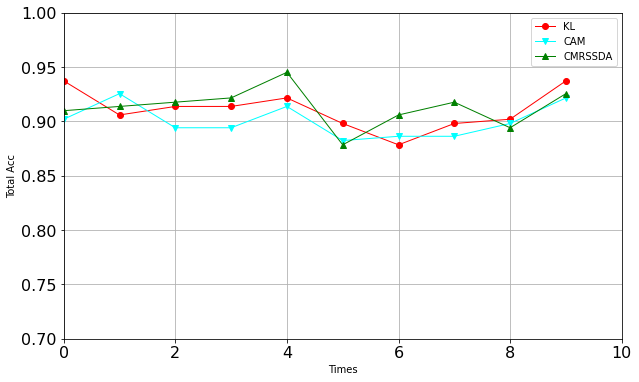

0.9105882352941178 0.9003921568627453 0.9129411764705884


In [200]:
marker_ =['.', 'o', 'v', '^', '<', '>', '1', '2', '*', '+', 'x', '3']
color = ['darkgreen','red','aqua','green','orange','cyan','dimgrey','black','blanchedalmond','blue','yellow']
labels = ['KL', 'CAM', 'CMRSSDA']
plt.figure(figsize=(10,6))
plt.tick_params(labelsize=16)
plt.grid(True)
# 绘制所有的
for n in range(3):
    x = np.arange(len(num_random_state))
    if n == 0:
        y = r_1
    if n == 1:
        y = r_2
    if n == 2:
        y = r_3
#     plt.plot(x,y,color=color[n+1], linewidth=1.0, marker=marker_[n+1], label=labels[n]+'__'+str(format(sum(y)/len(num_random_state), '.4f')))
    plt.plot(x,y,color=color[n+1], linewidth=1.0, marker=marker_[n+1], label=labels[n])
#     for i in range(0, len(x)):
#         plt.text(x[i],y[i], format(y[i], '.4f'))
    plt.legend(loc='best')
    plt.xlim(0,10)
    plt.ylim(0.7,1)
    plt.xlabel('Times')
    plt.ylabel('Total Acc')
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.08))
plt.show()
r_1c=sum(r_1)/len(num_random_state)
r_2c=sum(r_2)/len(num_random_state)
r_3c=sum(r_3)/len(num_random_state)
print(r_1c, r_2c, r_3c)

In [ ]:
KL                    CAM                CMRSSDA
***

0.7949019607843135 0.7878431372549018 0.7941176470588234
***

0.8047058823529412 0.7882352941176469 0.796862745098039
***

0.9105882352941178 0.9003921568627453 0.9129411764705884